# Effects of Different Qrel Patterns

We want to empirically verify that the LIMI dataset difficulty originates from dense query-document (qrel) pattern.

One way to do can be done by testing on less dense qrel patterns. We will examine the following query-document graph structures:

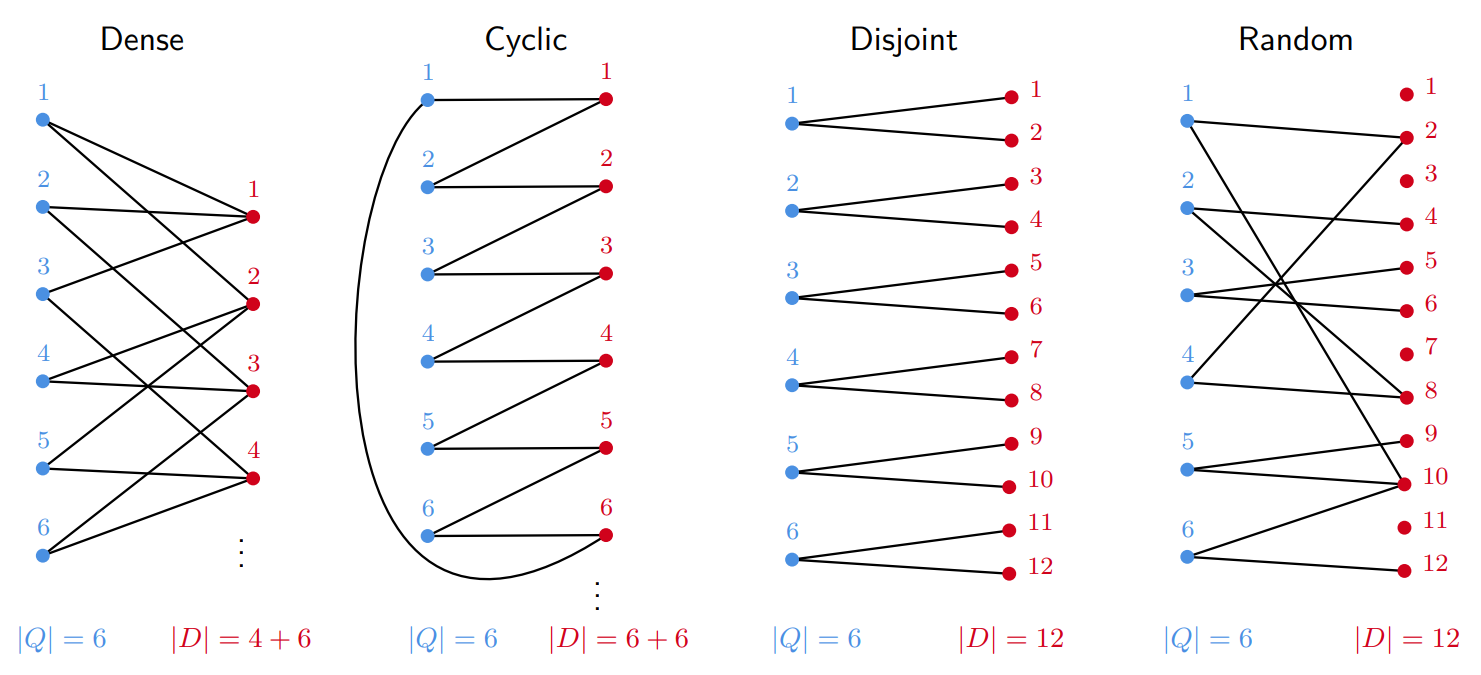

(Example to the different qrel patterns with $6$ queries, $12$ docs, $k = 2$ relevant doc/query)

## Binary qrel matrix generation

We first construct a dense representation of the previously mentioned qrel patterns, and generate the remaining documents during the natural language fill-in phase of dataset creation.

In [10]:
import numpy as np
from itertools import combinations
import random


def disjoint_matrix(num_of_queries: int, k: int = 2) -> np.ndarray:
    A = np.zeros((num_of_queries, k * num_of_queries), dtype=bool)

    rows = np.arange(num_of_queries).reshape(num_of_queries, 1)  # (N,1)
    starts = k * np.arange(num_of_queries).reshape(num_of_queries, 1)  # (N,1)
    offsets = np.arange(k).reshape(1, k)  # (1, k)

    cols = starts + offsets  # (N, k), via broadcasting

    A[rows, cols] = True
    return A


def cyclic_matrix(num_of_queries: int, k: int = 2) -> np.array:
    num_of_cols = (num_of_queries - 1) * (k - 1) + 1
    A = np.zeros((num_of_queries, num_of_cols), dtype=bool)

    rows = np.arange(num_of_queries).reshape(num_of_queries, 1)  # (N, 1)
    starts = (k - 1) * np.arange(num_of_queries).reshape(num_of_queries, 1)  # (N, 1)
    offsets = np.arange(k).reshape(1, k)  # (1, k)

    cols = (starts + offsets) % num_of_cols  # (N, k), via broadcasting

    A[rows, cols] = True
    return A


def dense_matrix(num_of_queries: int, num_of_docs: int, k: int = 2) -> np.array:
    all_indexes = np.arange(num_of_docs)
    A = np.zeros((num_of_queries, num_of_docs), dtype=bool)
    for row, combo in zip(range(num_of_queries), combinations(all_indexes, k)):
        A[row, combo] = True

    return A


def random_matrix(num_of_queries: int, num_of_docs: int, k: int = 2, seed: int = 42) -> np.array:
    random.seed(seed)
    all_indexes = np.arange(num_of_docs)
    combos_sample = random.sample(list(combinations(all_indexes, k)), num_of_queries)

    A = np.zeros((num_of_queries, num_of_docs), dtype=bool)
    for row, combo in zip(range(num_of_queries), combos_sample):
        A[row, combo] = True

    return A


In [11]:
import pandas as pd

def generate_dataset(
    liked_items: list[str],
    names: list[str],
    qrel_matrix: np.ndarray,
    items_per_person: int = 20,
    total_num_of_docs: int = 2000,
    seed: int = 42,
):
    num_of_queries, num_of_docs = qrel_matrix.shape
    random.seed(seed)

    query_items = random.sample(liked_items, num_of_queries)
    remaining_items = list(set(liked_items) - set(query_items))
    
    doc_ids = np.array(random.sample(names, num_of_docs))
    remaining_doc_ids = list(set(names) - set(doc_ids))
    
    docs = {}
    qrels_data = []
    
    # fill up the binary qrel structure with natural language
    for query_idx, (mask, item) in enumerate(zip(qrel_matrix, query_items)):
        selected_doc_ids = doc_ids[mask]
        for doc_id in selected_doc_ids:
            doc = docs.get(doc_id)
            if doc is None:
                docs[doc_id] = []
                doc = docs[doc_id]

            doc.append(item)
            qrels_data.append({
                "query-id": f"query_{query_idx}",
                "corpus-id": doc_id,
                "score": 1
            })
    
    # add remaining items to the docs
    for doc_id in docs:
        num_new_items_per_docs = items_per_person - len(docs[doc_id])
        new_items = random.sample(remaining_items, num_new_items_per_docs)
        docs[doc_id].extend(new_items)
        
    num_new_docs = total_num_of_docs - len(docs)
    if num_new_docs > 0:
        new_doc_ids = random.sample(remaining_doc_ids, num_new_docs)
        docs |= {
            doc_id: random.sample(remaining_items, items_per_person)
            for doc_id in new_doc_ids
        }
    
    # build and return the proper mteb format
    corpus = pd.DataFrame(
        [
            {
                "_id": doc_id,
                "title": "",
                "text": f"{doc_id} likes {', '.join(random.sample(docs[doc_id], len(docs[doc_id])))}."
            }
            for doc_id in docs
        ]
    )

    queries = pd.DataFrame(
        [
            {
                "_id": f"query_{query_idx}",
                "text": f"Who likes {item}?"
            }
            for query_idx, item in enumerate(query_items)
        ]
    )
    
    qrels = pd.DataFrame(qrels_data)
    
    return corpus, queries, qrels

In [12]:
df_names = pd.read_json("hf://datasets/orionweller/LIMIT/corpus.jsonl", lines=True)["_id"]
names = df_names.to_list()

df_items = pd.read_csv("/kaggle/input/generated-attributes/generated_attributes.csv")["liked_item"]
liked_items = df_items.to_list()

In [13]:
# A = dense_matrix(num_of_queries=23, num_of_docs=8)
# A = cyclic_matrix(num_of_queries=23)
# A = disjoint_matrix(num_of_queries=23)
A = random_matrix(num_of_queries=23, num_of_docs=2000)


corpus, queries, qrels = generate_dataset(
    liked_items=liked_items,
    names=names,
    qrel_matrix=A,
)

corpus.to_json("corpus.jsonl", orient="records", lines=True)
queries.to_json("queries.jsonl", orient="records", lines=True)
qrels.to_json("qrels.jsonl", orient="records", lines=True)

## Benchmarks on the generated datasets

The generated datasets are benchmarked using the same quantized models as before, following the pipeline in `limit_dataset_benchmark_models.ipynb`.

### Embed generated datasets

In [1]:
!nvidia-smi

Mon Jan 19 06:36:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
!pip install transformers torch bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 31.1 MB/s eta 0:00:00:00:0100:01


In [2]:
from sentence_transformers import SentenceTransformer
from abc import ABC, abstractmethod
import numpy as np


class EmbeddingModel(ABC):
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        pass

    @abstractmethod
    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        pass

        
class SnowflakeArcticL(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("Snowflake/snowflake-arctic-embed-l", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


class Qwen3Embed06B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


class E5Mistral7B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/e5-mistral-7b-instruct-bnb-4bit", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            # prompt_name="web_search_query", 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


class Qwen3Embed8B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/Qwen3-Embedding-8B-bnb-4bit", device="cuda")
    
    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

class GritLM7B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/GritLM-7B-bnb-4bit", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


2026-01-19 08:44:25.267016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768812265.567482      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768812265.662789      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768812266.584077      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768812266.584118      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768812266.584121      55 computation_placer.cc:177] computation placer alr

In [3]:
import pickle
import pandas as pd

def embed_dataset(
    model_type: type[EmbeddingModel], 
    batch_size: int,
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    saved_file_name_suffix: str
):    
    required_cols = {"_id", "text"}
    if not required_cols.issubset(corpus.columns):
        raise ValueError("Corpus must contain '_id' and 'text' columns")
    if not required_cols.issubset(queries.columns):
        raise ValueError("Queries must contain '_id' and 'text' columns")
    
    model = model_type()
    model_name = model.__class__.__name__
    
    embeddings = model.encode_docs(corpus["text"].to_list(), batch_size=batch_size)
    doc_embeddings = {_id: emb for _id, emb in zip(corpus["_id"], embeddings)}
    
    embeddings = model.encode_queries(queries["text"].to_list(), batch_size=batch_size)
    query_embeddings = {_id: emb for _id, emb in zip(queries["_id"], embeddings)}
    
    with open(f"{model_name}-{saved_file_name_suffix}.pkl", "wb") as file:
        pickle.dump([doc_embeddings, query_embeddings], file)

In [4]:
large_model_types = [E5Mistral7B, Qwen3Embed8B, GritLM7B]
small_model_types = [Qwen3Embed06B, SnowflakeArcticL]
model_types = large_model_types + small_model_types

dataset_types = ["disjoint", "dense", "cyclic", "random"]

dataset_type = dataset_types[3]
model_type = model_types[1]

print(f"dataset_type: {dataset_type}, model_type: {model_type}")

dataset_type: random, model_type: <class '__main__.Qwen3Embed8B'>


In [5]:
import pandas as pd

base_dir = f"/kaggle/input/limit-small-{dataset_type}-dataset"

corpus = pd.read_json(f"{base_dir}/corpus.jsonl", lines=True)
queries = pd.read_json(f"{base_dir}/queries.jsonl", lines=True)
qrels = pd.read_json(f"{base_dir}/qrels.jsonl", lines=True)

embed_dataset(
    model_type=model_type, 
    batch_size=32,
    corpus=corpus,
    queries=queries,
    saved_file_name_suffix=f"embeddings-limit-small-{dataset_type}"
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Calculate recalls on the generated embeddings for each dataset

In [43]:
import pandas as pd
import numpy as np
import pickle
from collections.abc import Callable

def create_benchmark(
    embbedings_path: str, 
    corpus: pd.DataFrame, 
    queries: pd.DataFrame, 
    qrels: pd.DataFrame
) -> Callable[[int, int], float]: 
    with open(embbedings_path, "rb") as file:
        doc_embs, query_embs = pickle.load(file)
    
    def recall_at(top_k: int, dimension: int) -> float:
        # align embedding matrices with corpus/query order (for safety)
        D = np.stack([doc_embs[_id] for _id in corpus["_id"]])
        Q = np.stack([query_embs[qid] for qid in queries["_id"]])
        D = D[:, :dimension]
        Q = Q[:, :dimension]
        D = D.astype(np.float64, copy=False)
        Q = Q.astype(np.float64, copy=False)
            
        A = Q @ D.T
        
        # uses quickselect under the hood
        # we need to select indexes of the top-k largest values -> -A
        retrieved_docs = np.argpartition(-A, kth=top_k-1, axis=1)[:, :top_k]
        
        retrieved_docs = [
            set(corpus["_id"].iloc[docs].to_list())
            for docs in retrieved_docs
        ]

        qrels_map = (
            qrels.groupby("query-id")["corpus-id"]
            .apply(set)
            .to_dict()
        )
        
        relevant_docs = [
            qrels_map[qid]
            for qid in queries["_id"]
        ]
    
        total = 0
        for ret, rel in zip(retrieved_docs, relevant_docs):
            total += len(ret & rel) / len(rel)
            
        return total / len(relevant_docs)

    return recall_at

In [ ]:
import matplotlib.pyplot as plt

def visualize(
    recalls_of: dict[str, dict[str, list[float]]],
    extra_model_name_suffix: str = "",
    save_diagram: bool = False,
    saved_diagram_name: str = None
):
    dims_to_plot = [32, 512, 1024, 2048, 3072, 4096]
    recalls_to_plot = [0, 0.2, 0.4, 0.6, 0.8, 1]
    dims = [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]
    
    mrl_model_names = {"SnowflakeArcticL", "Qwen3Embed8B", "Qwen3Embed06B"}
    extra_models = ["BM25", "GTEModernColBERT"]
    extra_model_colors = ["gray", "brown"]
    model_names = set(recalls_of[list(recalls_of.keys())[0]]) - set(extra_models)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    
    for i, dataset_type in enumerate(recalls_of):
        axis = axes[i]
        axis.set_title(dataset_type)
        axis.set_xlabel("Dimension")
        if i == 0:
            axis.set_ylabel("Recall@100")
        axis.set_ylim(0, 1.05)
        axis.set_xticks(dims_to_plot)
        axis.set_xticklabels([str(d) for d in dims_to_plot])
        axis.set_yticks(recalls_to_plot)
        axis.set_yticklabels([str(r) for r in recalls_to_plot])

        dataset_recalls = recalls_of[dataset_type]
        for model_name in model_names:
            model_recalls = dataset_recalls[model_name]
            axes[i].plot(
                dims, 
                model_recalls, 
                marker='*' if model_name in mrl_model_names else ".", 
                label=model_name
            )

    
        for model_name, color in zip(extra_models, extra_model_colors):
            model_recalls = dataset_recalls[model_name]
            axes[i].axhline(
                y=model_recalls[0],
                linestyle="--",
                linewidth=1.40,
                color=color,
                label=f"{model_name}{extra_model_name_suffix}"
            )
    
    # set legend by removing duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(), 
        by_label.keys(), 
        loc='lower center', 
        ncol=4, 
        bbox_to_anchor=(0.5, -0.1)
    )
        
    plt.tight_layout()
    plt.show()
    if save_diagram:
        saved_diagram_name = saved_diagram_name or "recalls_diagram.pdf"
        fig.savefig(saved_diagram_name, bbox_inches='tight')

#### Reproduced results

In [44]:
import pandas as pd

recalls = {}
dataset_types = ["disjoint", "dense", "cyclic", "random"]

for dataset_type in dataset_types:
    base_dir = f"/kaggle/input/limit-small-{dataset_type}-dataset"
    
    corpus = pd.read_json(f"{base_dir}/corpus.jsonl", lines=True)
    queries = pd.read_json(f"{base_dir}/queries.jsonl", lines=True)
    qrels = pd.read_json(f"{base_dir}/qrels.jsonl", lines=True)
    
    def recalls_for_model(model_name: str, dataset_type: str = dataset_type):
        recall_at = create_benchmark(
            embbedings_path=f"/kaggle/input/limit-dataset-benchmark/{model_name}-embeddings-limit-small-{dataset_type}.pkl",
            corpus=corpus, 
            queries=queries, 
            qrels=qrels
        )
        return recall_at
    
    model_names = [
        "Qwen3Embed8B",
        "E5Mistral7B",
        "Qwen3Embed06B",
        "GritLM7B",
        "SnowflakeArcticL"
    ]

    dims = [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]

    recalls[dataset_type] = {
        model_name : [
            recalls_for_model(model_name)(top_k=100, dimension=d)
            for d in dims
        ]
        for model_name in model_names
    }

new_recalls = {
    "dense": {
        "BM25": [0.9565217391304348],
        "GTEModernColBERT": [1]
    },
    "cyclic": {
        "BM25": [0.9565217391304348],
        "GTEModernColBERT": [0.9782608695652174]
    },
    "random": {
        "BM25": [0.9347826086956522],
        "GTEModernColBERT": [1]
    },
    "disjoint": {
        "BM25": [0.9130434782608695],
        "GTEModernColBERT": [0.9782608695652174]
    }
}

for dataset_type in dataset_types:
    recalls[dataset_type] |= new_recalls[dataset_type]

We can observe that the quantized models perform worse than certain smaller non-quantized models, as expected for 4-bit quantization.

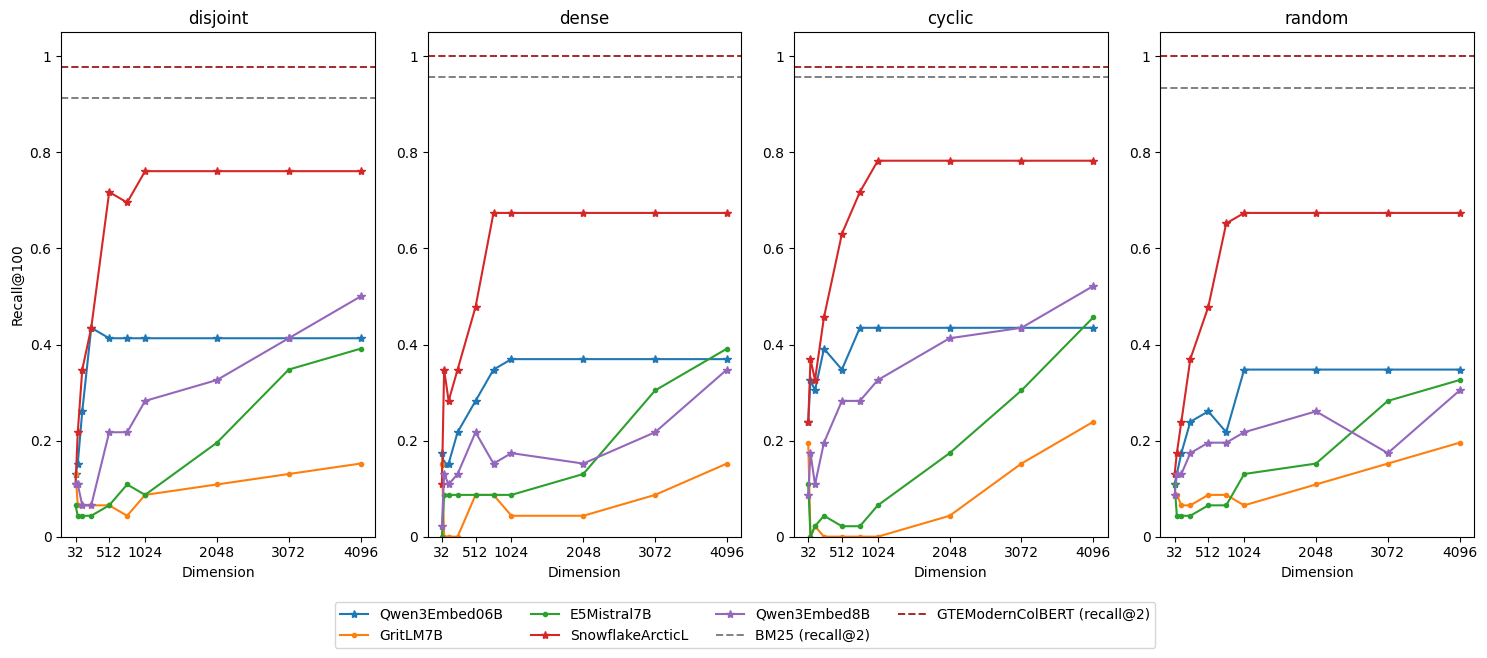

In [61]:
visualize(
    recalls, 
    extra_model_name_suffix=" (recall@2)",
    save_diagram=True, 
    saved_diagram_name="qrel_patterns_diagram.pdf"
)

#### Original results from the paper

In [3]:
# Original results from the paper
df_paper = pd.DataFrame([
    # BM25
    ["BM25", "default", 96.1, 93.0, 96.0, 96.6],

    # E5-Mistral 7B
    ["E5-Mistral 7B", 32, 1.7, 0.6, 1.7, 2.2],
    ["E5-Mistral 7B", 64, 4.3, 0.5, 3.3, 4.8],
    ["E5-Mistral 7B", 128, 10.3, 0.9, 9.1, 10.5],
    ["E5-Mistral 7B", 256, 16.9, 1.2, 14.0, 15.5],
    ["E5-Mistral 7B", 512, 26.4, 2.5, 24.0, 26.6],
    ["E5-Mistral 7B", 768, 31.5, 3.1, 27.7, 30.0],
    ["E5-Mistral 7B", 1024, 34.0, 3.8, 29.5, 32.8],
    ["E5-Mistral 7B", 2048, 36.8, 4.3, 33.6, 36.7],
    ["E5-Mistral 7B", 3072, 38.9, 4.7, 35.8, 37.6],
    ["E5-Mistral 7B", 4096, 40.4, 4.8, 36.6, 38.8],

    # GTE-ModernColBERT
    ["GTE-ModernColBERT", "default", 71.1, 61.8, 65.3, 70.1],

    # GritLM 7B
    ["GritLM 7B", 32, 1.5, 0.6, 1.9, 1.5],
    ["GritLM 7B", 64, 3.6, 0.6, 2.9, 3.9],
    ["GritLM 7B", 128, 8.0, 1.6, 6.3, 8.4],
    ["GritLM 7B", 256, 15.8, 2.0, 14.4, 16.0],
    ["GritLM 7B", 512, 33.7, 4.5, 29.5, 33.8],
    ["GritLM 7B", 768, 39.0, 5.6, 34.4, 40.1],
    ["GritLM 7B", 1024, 43.3, 6.6, 37.4, 44.1],
    ["GritLM 7B", 2048, 55.3, 9.0, 49.0, 55.8],
    ["GritLM 7B", 3072, 61.5, 10.9, 54.3, 61.6],
    ["GritLM 7B", 4096, 61.8, 10.4, 56.6, 63.2],

    # Qwen3 Embed
    ["Qwen3 Embed", 32, 3.2, 0.7, 2.7, 2.6],
    ["Qwen3 Embed", 64, 5.4, 1.1, 5.0, 5.7],
    ["Qwen3 Embed", 128, 9.9, 1.9, 7.9, 9.4],
    ["Qwen3 Embed", 256, 14.2, 2.4, 11.6, 12.5],
    ["Qwen3 Embed", 512, 18.0, 3.3, 14.7, 15.9],
    ["Qwen3 Embed", 768, 19.5, 3.5, 15.5, 18.0],
    ["Qwen3 Embed", 1024, 20.4, 3.6, 16.1, 18.7],
    ["Qwen3 Embed", 2048, 22.3, 4.1, 17.2, 21.4],
    ["Qwen3 Embed", 3072, 21.9, 4.3, 17.9, 21.1],
    ["Qwen3 Embed", 4096, 22.7, 4.5, 17.8, 20.9],

    # Snowflake Arctic L
    ["Snowflake Arctic L", 32, 1.5, 0.7, 1.4, 1.6],
    ["Snowflake Arctic L", 64, 3.5, 0.5, 3.3, 3.1],
    ["Snowflake Arctic L", 128, 8.1, 1.1, 6.8, 7.6],
    ["Snowflake Arctic L", 256, 15.8, 1.6, 12.3, 14.0],
    ["Snowflake Arctic L", 512, 17.9, 2.3, 14.0, 16.3],
    ["Snowflake Arctic L", 768, 19.3, 2.5, 15.9, 18.6],
    ["Snowflake Arctic L", 1024, 21.0, 2.4, 17.6, 20.0],
    ["Snowflake Arctic L", 2048, 21.0, 2.4, 17.6, 20.0],
    ["Snowflake Arctic L", 3072, 21.0, 2.4, 17.6, 20.0],
    ["Snowflake Arctic L", 4096, 21.0, 2.4, 17.6, 20.0],
], columns=["Model", "Dim", "Random", "Dense", "Cycle", "Disjoint"])

In [4]:
df_paper

,Model,Dim,Random,Dense,Cycle,Disjoint
0,BM25,default,96.1,93.0,96.0,96.6
1,E5-Mistral 7B,32,1.7,0.6,1.7,2.2
2,E5-Mistral 7B,64,4.3,0.5,3.3,4.8
3,E5-Mistral 7B,128,10.3,0.9,9.1,10.5
4,E5-Mistral 7B,256,16.9,1.2,14.0,15.5
5,E5-Mistral 7B,512,26.4,2.5,24.0,26.6
6,E5-Mistral 7B,768,31.5,3.1,27.7,30.0
7,E5-Mistral 7B,1024,34.0,3.8,29.5,32.8
8,E5-Mistral 7B,2048,36.8,4.3,33.6,36.7
9,E5-Mistral 7B,3072,38.9,4.7,35.8,37.6


In [5]:
df_paper["Model"].unique()

array(['BM25', 'E5-Mistral 7B', 'GTE-ModernColBERT', 'GritLM 7B',
       'Qwen3 Embed', 'Snowflake Arctic L'], dtype=object)

In [50]:
shortened_name_of = {
    "BM25": "BM25",
    "E5-Mistral 7B": "E5Mistral7B",
    "GTE-ModernColBERT": "GTEModernColBERT",
    "GritLM 7B": "GritLM7B",
    "Qwen3 Embed": "Qwen3Embed8B",
    "Snowflake Arctic L": "SnowflakeArcticL"
}

df_paper["shortened_name"] = df_paper["Model"].apply(lambda n: shortened_name_of[n])
df_paper = df_paper.rename(
    columns={
        "Random": "random",
        "Dense": "dense",
        "Cycle": "cyclic",
        "Disjoint": "disjoint",
    }
)

In [51]:
df_paper

,Model,Dim,random,dense,cyclic,disjoint,shortened_name
0,BM25,default,96.1,93.0,96.0,96.6,BM25
1,E5-Mistral 7B,32,1.7,0.6,1.7,2.2,E5Mistral7B
2,E5-Mistral 7B,64,4.3,0.5,3.3,4.8,E5Mistral7B
3,E5-Mistral 7B,128,10.3,0.9,9.1,10.5,E5Mistral7B
4,E5-Mistral 7B,256,16.9,1.2,14.0,15.5,E5Mistral7B
5,E5-Mistral 7B,512,26.4,2.5,24.0,26.6,E5Mistral7B
6,E5-Mistral 7B,768,31.5,3.1,27.7,30.0,E5Mistral7B
7,E5-Mistral 7B,1024,34.0,3.8,29.5,32.8,E5Mistral7B
8,E5-Mistral 7B,2048,36.8,4.3,33.6,36.7,E5Mistral7B
9,E5-Mistral 7B,3072,38.9,4.7,35.8,37.6,E5Mistral7B


In [55]:
dataset_types = ["disjoint", "dense", "cyclic", "random"]
paper_results_by = dict(tuple(df_paper.groupby("shortened_name")[dataset_types]))

paper_recalls = {
    dataset_type: {
        model_name: paper_results_by[model_name][dataset_type].apply(lambda x: x / 100).to_list()
        for model_name in paper_results_by
    }
    for dataset_type in dataset_types
}

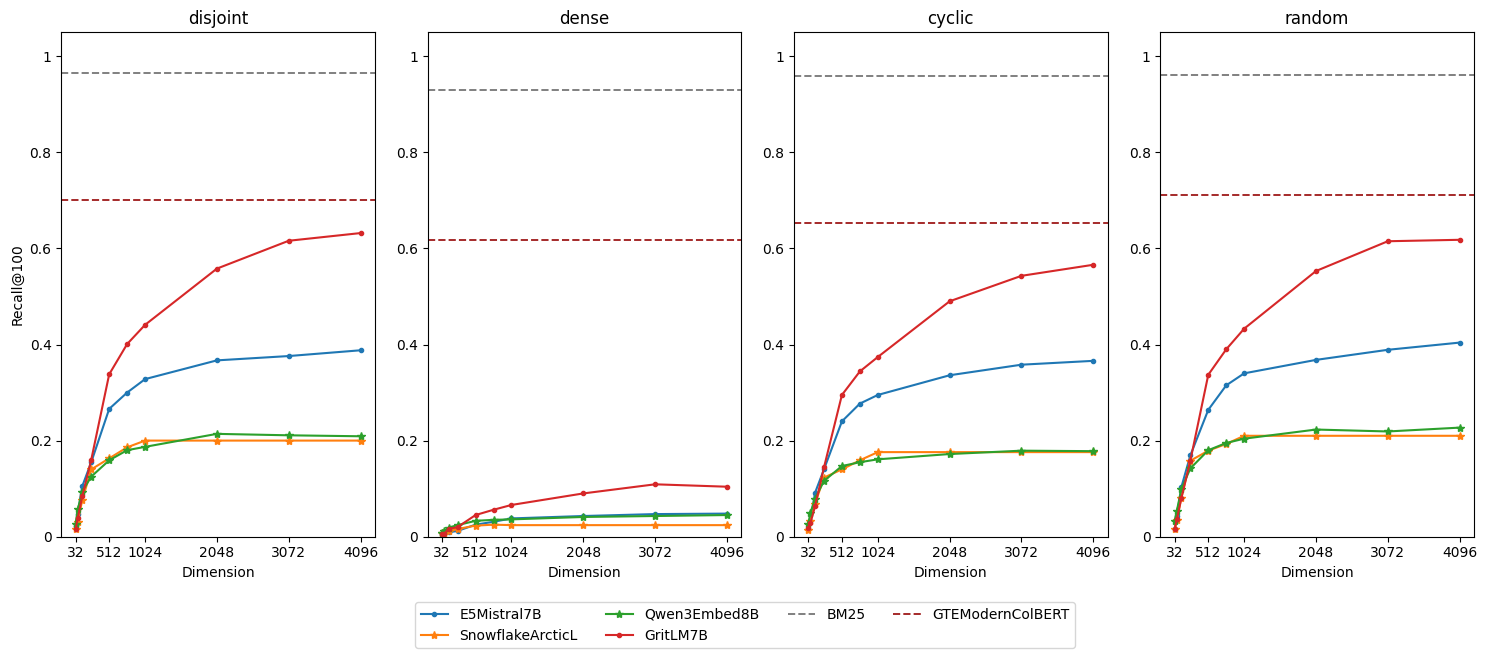

In [63]:
visualize(
    paper_recalls,
    save_diagram=True, 
    saved_diagram_name="expected_qrel_patterns_diagram.pdf"
)